In [1]:
import os
from PIL import Image

# Click

http://click.pocoo.org/6/

In [2]:
%%file ../scripts/image-ui/segment.py
import io

import numpy as np
import skimage.filters
import scipy.misc
import click

def open_image(filename, mode="L"):
    return scipy.misc.imread(filename, mode=mode)

def save_image(filename, image):
    scipy.misc.imsave(filename, image)
    
def segment_image(image):
    th = skimage.filters.threshold_otsu(image)
    segmented = np.zeros_like(image)
    segmented[image > th] = 255
    return segmented

@click.command()
@click.argument("src", type=click.Path(exists=True, readable=True, dir_okay=False))
@click.argument("dst", type=click.Path(writable=True, dir_okay=False))
def main(src, dst):
    image = open_image(src)
    segmented = segment_image(image)
    save_image(dst, segmented)
    

if __name__ == '__main__':
    main()

Overwriting ../scripts/image-ui/segment.py


In [3]:
if os.path.exists('tmp.jpg'): os.remove('tmp.jpg')
!python ../scripts/image-ui/segment.py ../data/Kobe_Bryant_2014_small.jpg tmp.jpg

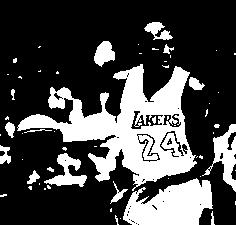

In [4]:
Image.open('tmp.jpg')

# Tk

[ImageTk](http://pillow.readthedocs.io/en/latest/reference/ImageTk.html)

Install Pillow from http://www.lfd.uci.edu/~gohlke/pythonlibs/#pillow

In [5]:
%gui tk
import tkinter
import tkinter.messagebox

import pygubu
from PIL import Image, ImageTk
import numpy as np

import sys
sys.path.append("../scripts/image-ui/")
from segment import segment_image


class ImageGUI:
    def __init__(self, master):
        self.master = master
        self.builder = builder = pygubu.Builder()
        self.builder.add_from_file('../scripts/image-ui/image.ui')
        
        self.mainwindow = builder.get_object('mainwindow', master)        
        self.filenameEntry = builder.get_object('filenameEntry', master)
        self.imageLabel = builder.get_object('imageLabel', master)
        self.saveButton = builder.get_object('saveButton', master)
        self.loadButton = builder.get_object('loadButton', master)
        self.segmentButton = builder.get_object('segmentButton', master)
        
        self.filename = tkinter.StringVar(value='../data/Kobe_Bryant_2014_small.jpg')
        self.filenameEntry['textvariable'] = self.filename        
        self.load()
        
        self.saveButton['command'] = self.save
        self.loadButton['command'] = self.load
        self.segmentButton['command'] = self.segment
    
    
    def info(self, title, msg):
        tkinter.messagebox.showinfo(title, msg)
        
    def error(self, title, msg):
        tkinter.messagebox.showerror(title, msg)
    
    def load(self):
        fn = self.filename.get()
        try:
            self.image = Image.open(fn).convert("L")
        except Exception as e:
            self.error("Failed loading image", e)
        self.imageTk = ImageTk.PhotoImage(self.image)
        self.imageLabel.config(image=self.imageTk)

    def save(self):
        fn = self.filename.get()
        try:
            self.image.save(fn)
        except Exception as e:
            self.error("Failed saving image", e)
        else:
            self.info("Saved image", "Image save to {}".format(fn))
        
    def update(self):
        self.imageTk.paste(self.image)        
        self.imageLabel.config(image=self.imageTk)
        
    def segment(self):
        segmented = segment_image(np.array(self.image))
        self.image = Image.fromarray(segmented)
        self.update()

app = tkinter.Tk()
app.title("ImageGUI")
window = ImageGUI(app)

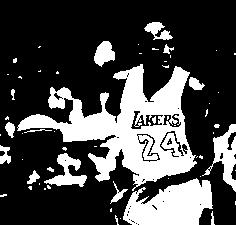

In [6]:
Image.open('tmp.jpg')

# Flask 

# Requests

http://docs.python-requests.org/en/master/user/quickstart/#post-a-multipart-encoded-file

http://code.runnable.com/UiPcaBXaxGNYAAAL/how-to-upload-a-file-to-the-server-in-flask-for-python

https://pythonhosted.org/Flask-Uploads/

In [7]:
import io

import requests
from PIL import Image

base_url = "http://127.0.0.1:5000"

In [8]:
with open('../data/Kobe_Bryant_2014_small.jpg', 'rb') as f:
    resp = requests.post(base_url + "/upload", files={'file': f})
assert resp.ok, resp.reason
print(resp.json())

{'image_id': 'f86bac00-1b2f-4016-8e72-e912993484d8', 'url': '/images/f86bac00-1b2f-4016-8e72-e912993484d8'}


In [9]:
resp = requests.get(base_url + "/segment/" + resp.json()['image_id'])
assert resp.ok, resp.reason
print(resp.json())

{'image_id': '5ba3c32f-5573-447a-a133-ab3d050e28c4', 'url': '/images/5ba3c32f-5573-447a-a133-ab3d050e28c4'}


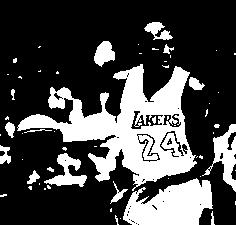

In [10]:
resp = requests.get(base_url + resp.json()['url'])
assert resp.ok, resp.reason
Image.open(io.BytesIO(resp.content))

# Click + Requests

In [11]:
%%file ../scripts/image-ui/segment_client.py
import io

import requests
import click

base_url = "http://127.0.0.1:5000"

def error(msg):
    click.secho(msg, fg="red")

def upload_image(filename):
    url = "{}/upload".format(base_url)
    with open(filename, 'rb') as f:
        resp = requests.post(url, files={'file': f})        
    if not resp.ok:
        raise Exception(resp.reason)
    return resp.json()['image_id']

def download_image(url, filename=None):
    resp = requests.get(url)
    if not resp.ok:
        raise Exception(resp.reason)
    if filename is not None:
        with open(filename, "wb") as f:
            f.write(resp.content)
    else:
        return io.BytesIO(resp.content)
        
def segment_image(image_id):
    url = "{}/segment/{}".format(base_url, image_id)
    resp = requests.get(url)
    if not resp.ok:
        raise Exception(resp.reason)
    return base_url + resp.json()['url']

@click.command()
@click.argument("src", type=click.Path(exists=True, readable=True, dir_okay=False))
@click.argument("dst", type=click.Path(writable=True, dir_okay=False))
def main(src, dst):    
    image_id = upload_image(src)
    url = segment_image(image_id)    
    download_image(url, dst)

if __name__ == '__main__':
    main()

Overwriting ../scripts/image-ui/segment_client.py


In [12]:
if os.path.exists('tmp.jpg'): os.remove('tmp.jpg')
!python ../scripts/image-ui/segment_client.py ../data/Kobe_Bryant_2014_small.jpg tmp.jpg

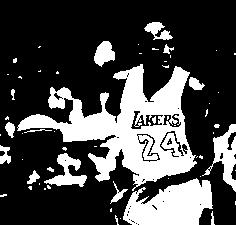

In [13]:
Image.open('tmp.jpg')

# Tk + Requests

In [14]:
%gui tk
from segment_client import upload_image, download_image, segment_image


class ImageClientGUI(ImageGUI):

    def segment(self):
        try:
            image_id = upload_image(self.filename.get())
        except Exception as e:
            self.error("Upload failed", e)
            return
        try:
            url = segment_image(image_id)
        except Exception as e:
            self.error("Segmentation failed", e)
            return
        try:
            image_file = download_image(url)
        except Exception as e:
            self.error("Download failed", e)
            return

        self.image = Image.open(image_file)
        self.update()

app = tkinter.Tk()
app.title("ImageClientGUI")
window = ImageClientGUI(app)